In [6]:
PATH <- file.path("C:/Users/julia/OneDrive - London School of Hygiene and Tropical Medicine/Documents/LSHTM/Project") #"/home/andewegs/1_RSV_scripts/"
setwd(PATH)
#getwd()
library(tidyverse)
rsv.data <- read_csv(file = "Data/infection_status.csv")

Rows: 682 Columns: 23
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (20): age_days, infection, IgG_PreF, IgA_PreF, IgG_PostF, IgA_PostF, Ig...
lgl   (1): IgA_Nn_household
date  (2): birthday, consultdate

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
#get true number of infected and recovered children
rsv_by_age <- rsv.data %>% arrange(age_days)
tab <- table(rsv_by_age$age_days, rsv_by_age$infection)
true_hist <- data.frame(age=rownames(tab), infected=tab[,2])
true_hist$age <- as.numeric(true_hist$age)
true_hist$cuminfection <- cumsum(true_hist$infected)
tail(true_hist)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


In [8]:
#add susceptible
N <- nrow(rsv_by_age)
true_hist$susceptible <- N - true_hist$cuminfection
true_hist$recovered <- true_hist$cuminfection - true_hist$infected
tail(true_hist)

,age,infected,cuminfection,susceptible,recovered
,<dbl>,<int>,<int>,<int>,<int>
1808,1808,1,339,343,338
1821,1821,1,340,342,339
1823,1823,1,341,341,340
1841,1841,2,343,339,341
1843,1843,1,344,338,343
1854,1854,1,345,337,344


In [9]:
#rearrange the columns in the right order
true_hist<-true_hist[,c(1,4,2,5,3)]
tail (true_hist)

,age,susceptible,infected,recovered,cuminfection
,<dbl>,<int>,<int>,<int>,<int>
1808,1808,343,1,338,339
1821,1821,342,1,339,340
1823,1823,341,1,340,341
1841,1841,339,2,341,343
1843,1843,338,1,343,344
1854,1854,337,1,344,345


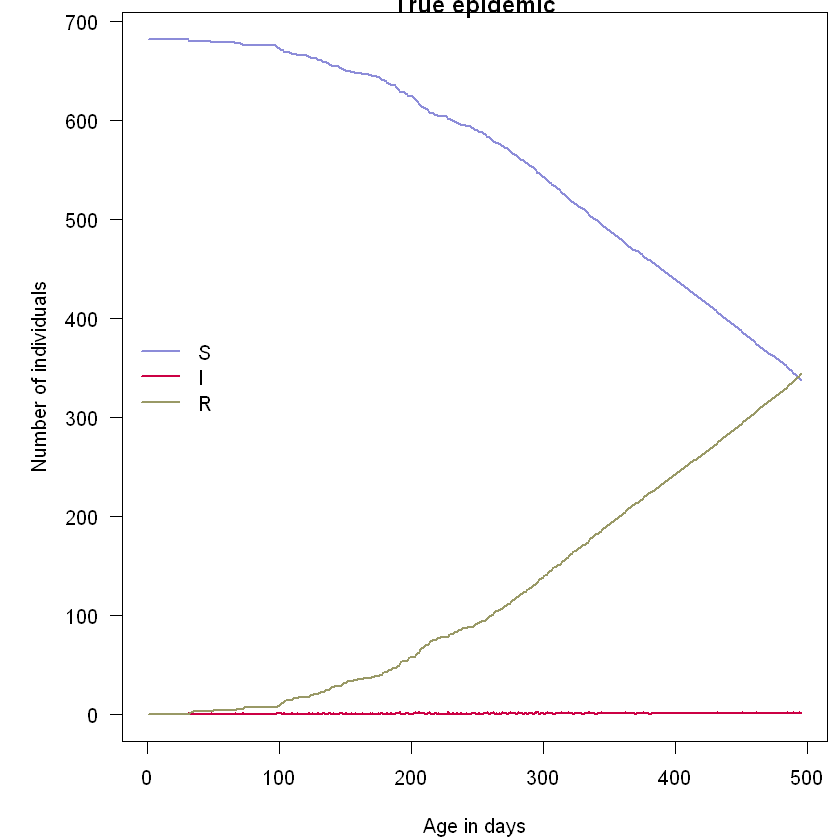

In [10]:
cols <- names(true_hist) %in% c('age', 'cuminfection')
hist_no_time <- true_hist[!cols]
par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966")
matplot(hist_no_time, type = "l", 
        xlab = "Age in days", ylab = "Number of individuals",
        col = cols, lty = 1, lwd = 2)
legend("left", lwd = 2, col = cols, legend = names(cols), bty = "n")
title("True epidemic", line = 0)

In [11]:
#build a true history with all days
min = head(true_hist$age,1)
max = tail(true_hist$age,1)
days <- seq(min, max)
infected <- rep(0, max-min+1)
susceptible <- rep(0, max-min+1)
recovered <- rep(0, max-min+1)

true_hist_all <- data.frame(days, susceptible,infected, recovered)

In [12]:
for (d in seq_along(true_hist_all$days)){
    for (a in seq_along(true_hist$age)){
     if (true_hist_all$days[d] == true_hist$age[a]){
         true_hist_all$susceptible[d] <- true_hist$susceptible[a]
         true_hist_all$infected[d] <- true_hist$infected[a]
         true_hist_all$recovered[d] <- true_hist$recovered[a]
     }
   }
}

In [13]:
for (d in seq_along(true_hist_all$days)){
     if (true_hist_all$susceptible[d] == 0){
         true_hist_all$susceptible[d] <- true_hist_all$susceptible[d-1]
     }
}

In [14]:
N = nrow(rsv_by_age)
true_hist_all$recovered <- N - true_hist_all$susceptible - true_hist_all$infected
true_hist_all$total <- true_hist_all$susceptible + true_hist_all$infected + true_hist_all$recovered

In [15]:
#check that the values make sense
for (d in seq_along(true_hist_all$days)){
     if (true_hist_all$total[d] != nrow(rsv_by_age)){
         print("Wrong total in row", d)
     }
    if (true_hist_all$days[d] <36){
        if (true_hist_all$susceptible[d] > true_hist_all$susceptible[d-1]){
            print("Suscpetible increasing in row ", d)
            }
        if (true_hist_all$recovered[d] < true_hist_all$recovered[d-1]){
            print("Recovered decreasing in row ", d)
            }
        }
   }

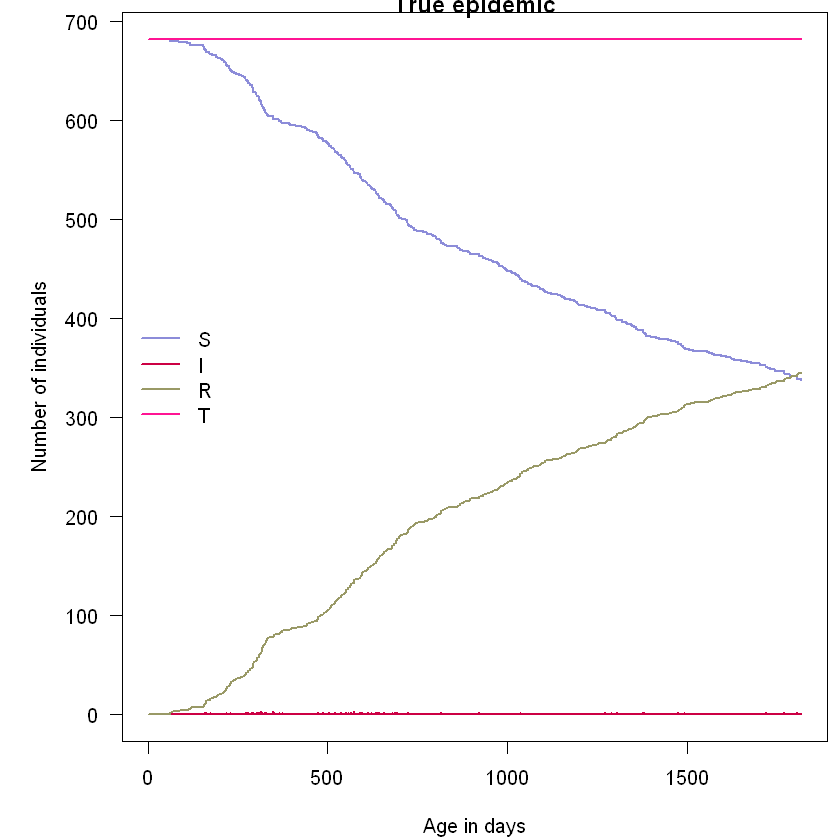

In [18]:
#png("true epidemic.png")
cols <- names(true_hist_all) %in% c('days', 'cuminfection')
hist_no_time <- true_hist_all[!cols]
par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966", T = "#FF1493")
matplot(hist_no_time, type = "l", 
        xlab = "Age in days", ylab = "Number of individuals",
        col = cols, lty = 1, lwd = 2)
legend("left", lwd = 2, col = cols, legend = names(cols), bty = "n")
title("True epidemic", line = 0)
#dev.off()

In [93]:
#export it as a csv
write.csv(true_hist_all,"true_history.csv", row.names = FALSE)

Now mcstate

In [19]:
rsv_by_age <- rsv.data %>% arrange(age_days)
tab <- table(rsv_by_age$age_days, rsv_by_age$infection)
dframe <- data.frame(age=rownames(tab), infected=tab[,2])
dframe$age <- as.numeric(dframe$age)
dframe$cuminfection <- cumsum(dframe$infected)

In [20]:
tail(dframe)

,age,infected,cuminfection
,<dbl>,<int>,<int>
1808,1808,1,339
1821,1821,1,340
1823,1823,1,341
1841,1841,2,343
1843,1843,1,344
1854,1854,1,345


In [21]:
#get only participants aged 97 days or more
dframe2 <- subset(dframe, age>=97)

In [22]:
#define a dataframe with all days between the youngest age and the oldest age
min = head(dframe2$age,1)
max = tail(dframe2$age,1)
days <- seq(min, max)
infections <- rep(0, max-min+1)

df <- data.frame(days, infections)

In [23]:
for (d in seq_along(df$days))
    for (a in seq_along(dframe2$age))
     if (df$days[d] == dframe2$age[a])
         df$infections[d] <- dframe2$infected[a]

In [24]:
dt <- 1
sir_data <- mcstate::particle_filter_data(data = df,
                                          time = "days",
                                          rate = 1 / dt)
head(rmarkdown::paged_table(sir_data))

,days_start,days_end,step_start,step_end,infections
,<int>,<int>,<int>,<int>,<dbl>
1,96,97,96,97,2
2,97,98,97,98,0
3,98,99,98,99,0
4,99,100,99,100,0
5,100,101,100,101,0
6,101,102,101,102,1


In [25]:
case_compare <- function(state, observed, pars = NULL) {
  exp_noise <- 1e6

  incidence_modelled <- state[4 , drop = TRUE]
  incidence_observed <- observed$infections
  lambda <- incidence_modelled +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = incidence_observed, lambda = lambda, log = TRUE)
}

In [26]:
incidence_compare <- function(state, prev_state, observed, pars = NULL) {
  exp_noise <- 1e6

  lambda <- state[4, , drop = TRUE] +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = observed$infections, lambda = lambda, log = TRUE)
}

In [64]:
nrow(rsv_by_age)

[1] 682

In [27]:

setwd("C:/Users/julia")
getwd()

[1] "C:/Users/julia"

In [58]:
#model with S = 682
library(odin.dust)
gen_sir <- odin.dust::odin_dust("sir.R")
sir_model <- gen_sir$new(pars = list(), step = 0, n_particles = 3L)

i 18 functions decorated with [[cpp11::register]]

v generated file cpp11.R

v generated file cpp11.cpp

Re-compiling sirf3f2060a



-  installing *source* package 'sirf3f2060a' ... (477ms)
   ** using staged installation
   ** libs
   g++  -std=gnu++11 -I"C:/Users/julia/anaconda3/lib/R/include" -DNDEBUG  -I'C:/Users/julia/anaconda3/Lib/R/library/cpp11/include'     -IC:/Users/julia/anaconda3/Lib/R/library/dust/include -DHAVE_INLINE -fopenmp   -O2 -Wall  -march=x86-64 -mtune=generic  -Wall -pedantic -c cpp11.cpp -o cpp11.o
   g++  -std=gnu++11 -I"C:/Users/julia/anaconda3/lib/R/include" -DNDEBUG  -I'C:/Users/julia/anaconda3/Lib/R/library/cpp11/include'     -IC:/Users/julia/anaconda3/Lib/R/library/dust/include -DHAVE_INLINE -fopenmp   -O2 -Wall  -march=x86-64 -mtune=generic  -Wall -pedantic -c dust.cpp -o dust.o
   dust.cpp: In function 'cpp11::sexp dust::dust_info(const dust::pars_type<T>&) [with T = sir]':
   dust.cpp:298:28: warning: variable 'internal' set but not used [-Wunused-but-set-variable]
     298 |   const sir::internal_type internal = pars.internal;
         |                            ^~~~~~~~
   g++ -s

i Loading sirf3f2060a



In [29]:
sir_model$n_particles()

[1] 3

In [59]:
n_particles <- 1
filter <- mcstate::particle_filter$new(data = sir_data,
                                       model = gen_sir,
                                       n_particles = n_particles,
                                       compare = case_compare,
                                       seed = 3L)

In [60]:
sir_model$info()

$dim
$dim$time
[1] 1

$dim$S
[1] 1

$dim$I
[1] 1

$dim$R
[1] 1


$len
[1] 4

$index
$index$time
[1] 1

$index$S
[1] 2

$index$I
[1] 3

$index$R
[1] 4

In [40]:
index <- rep(2, 100)
sir_model$set_index(index)

In [43]:
sir_model$info()

$dim
$dim$time
[1] 1

$dim$S
[1] 1

$dim$I
[1] 1

$dim$R
[1] 1


$len
[1] 4

$index
$index$time
[1] 1

$index$S
[1] 2

$index$I
[1] 3

$index$R
[1] 4

In [61]:
filter$run(save_history = TRUE, pars = list(dt = dt))

[1] -3303.194

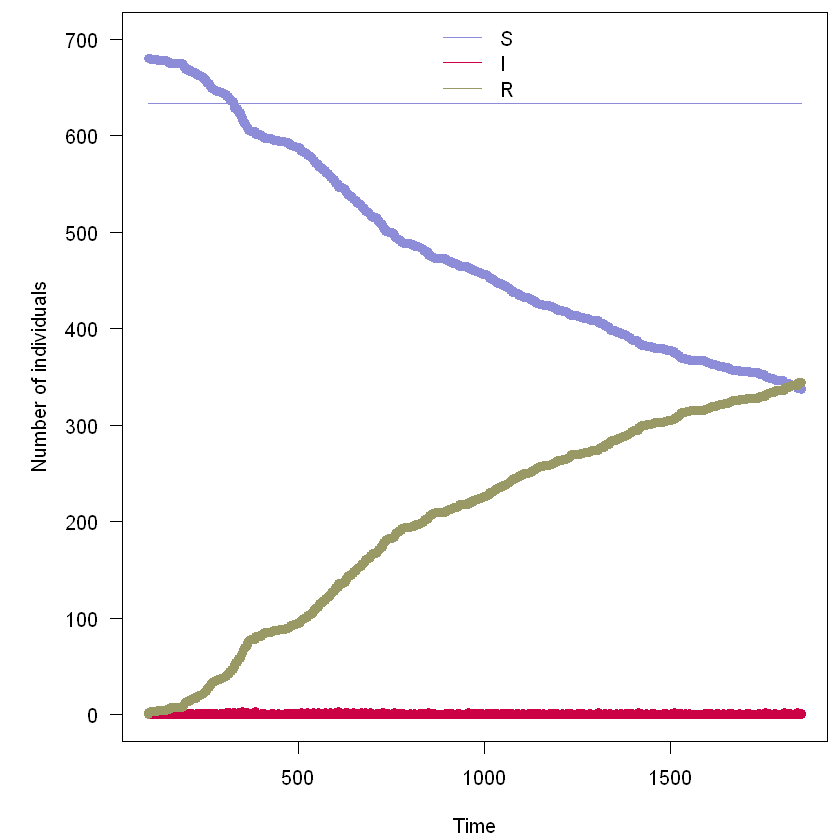

In [62]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, (history[4, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["R"]], lty = 1, ylim = c(0, 700))
  matlines(times, (history[2, , -1]), col = cols[["S"]], lty = 1)
  matlines(times, (history[3, , -1]), col = cols[["I"]], lty = 1)
  matpoints(t(times), t(true_history[,2, -1]), pch = 19,col = cols["S"])
  matpoints(t(times), t(true_history[,3, -1]), pch = 19,col = cols["I"])
  matpoints(t(times), t(true_history[,4, -1]), pch = 19,col = cols["R"])
  legend("top", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

true_history <- subset(true_hist_all, days>=97)
plot_particle_filter(filter$history(), true_history, df$days)

**Trying to infer parameters**

In [63]:
beta <- mcstate::pmcmc_parameter("beta", 2, min = 0)
gamma <- mcstate::pmcmc_parameter("gamma", 0.22, min = 0)

proposal_matrix <- diag(0.1, 2)
mcmc_pars <- mcstate::pmcmc_parameters$new(list(beta = beta, gamma = gamma),
                                           proposal_matrix)

In [64]:
n_steps <- 500
n_burnin <- 200
control <- mcstate::pmcmc_control(
    n_steps,
    save_state = TRUE,
    save_trajectories = TRUE,
    progress = TRUE)
pmcmc_run <- mcstate::pmcmc(mcmc_pars, filter, control = control)

Running chain 1 / 1


Step 1 / 500 [-------------------------------------] ETA  3m | 00:00:00 so far

Step 2 / 500 [-------------------------------------] ETA  3m | 00:00:00 so far

Step 3 / 500 [-------------------------------------] ETA  3m | 00:00:01 so far

Step 4 / 500 [-------------------------------------] ETA  3m | 00:00:01 so far

Step 5 / 500 [-------------------------------------] ETA  3m | 00:00:01 so far

Step 6 / 500 [-------------------------------------] ETA  3m | 00:00:02 so far

Step 7 / 500 [>------------------------------------] ETA  3m | 00:00:02 so far

Step 8 / 500 [>------------------------------------] ETA  3m | 00:00:02 so far

Step 9 / 500 [>------------------------------------] ETA  3m | 00:00:03 so far

Step 10 / 500 [>-----------------------------------] ETA  3m | 00:00:03 so far

Step 11 / 500 [>-----------------------------------] ETA  3m | 00:00:03 so far

Step 12 / 500 [>-----------------------------------] ETA  3m | 00:00:04 so far

Step 13 / 500 [>--

In [65]:
processed_chains <- mcstate::pmcmc_thin(pmcmc_run, burnin = n_burnin, thin = 2)
parameter_mean_hpd <- apply(processed_chains$pars, 2, mean)
parameter_mean_hpd

beta     gamma 
0.5382455 4.7200304

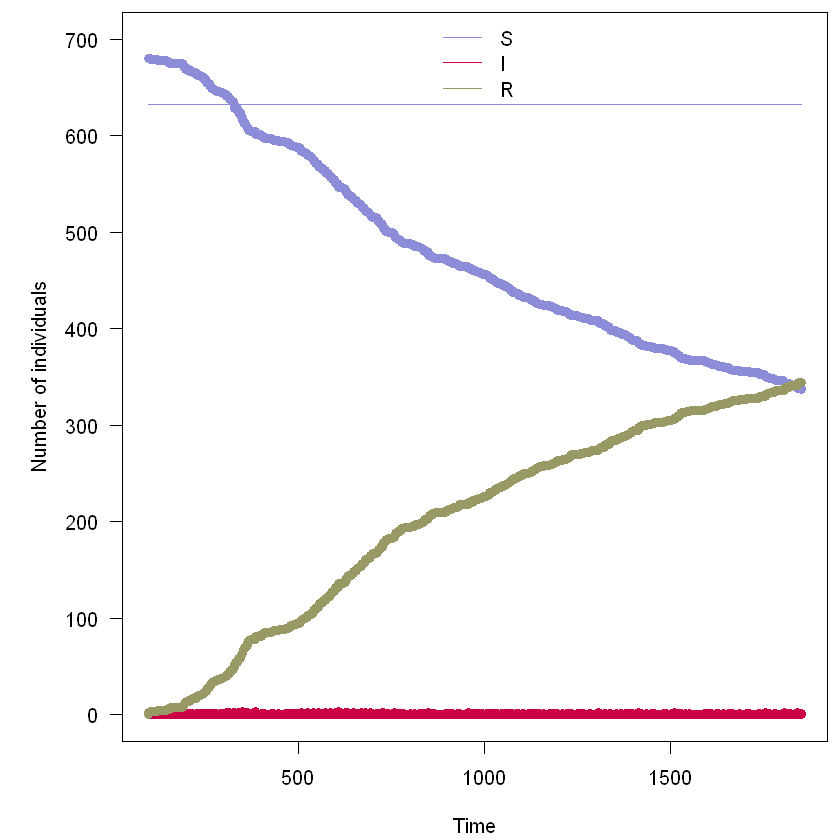

In [66]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, (history[4, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["R"]], lty = 1, ylim = c(0, 700))
  matlines(times, (history[2, , -1]), col = cols[["S"]], lty = 1)
  matlines(times, (history[3, , -1]), col = cols[["I"]], lty = 1)
  matpoints(t(times), t(true_history[,2, -1]), pch = 19,col = cols["S"])
  matpoints(t(times), t(true_history[,3, -1]), pch = 19,col = cols["I"])
  matpoints(t(times), t(true_history[,4, -1]), pch = 19,col = cols["R"])
  legend("top", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

true_history <- subset(true_hist_all, days>=97)
plot_particle_filter(filter$history(), true_history, df$days)

In [67]:
filter$run(save_history = TRUE, pars = list(dt = dt))

[1] -862302.9